<a href="https://colab.research.google.com/github/julianencisoizquierdo/NLP_Python_disaster_tweets/blob/main/NLP_Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'disaster-tweets:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4343103%2F7462099%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240204%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240204T175141Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dbc8ebc6d766f2daf67553cd3f40af2a8291a54fc589622473f6059309a9b90bb9bbb65156ebd7ee37f3deb77eded475e24ab40a9c4c3e8fead59f01f1fed4930b55f1d05f0aefdfa9970ab12b06235077718266652c2a7686ef1b965fe3b57894241c6717087c4cb0820fd66b2dec361252a1eac6ee14bf813b1176c49414edb6464577b8cd455fb86859480b513a09c47eb41f4be6ab9e479173fbaeecad18948390d95391ae0d20fcf5bdc91d2747a361fda528c81f2995d5289618beb00f84d83003607e847fc4ccb511f69a476e80d7318d6b31c384d22f233d5cb40edceebcb52f7386454c648e8f966f8bcf7d24dec612ce0cb50780e4fecf7d7395421,frequency-dictionary:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4361383%2F7490938%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240204%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240204T175141Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0a5322989c9ed5cdb5113a2e4fccf24a18e40799f288e7474daebf18021ac1ce131fd3d13e95e92ed9e8627dca035e97ee36b9bf179dbaaf0a2209aa2804f773120e3a5f70192e0f6ba3bad3efda2adf3c31100baa15d04b964f41748ab8a83b681a4aa2ff331b916d901b1351a4fc7c809134b01e92032ea6ddf7a3d80c9cfa61ecfa52c15a06013ca72aadf17a99d123f62a507fe63b26c19c7c57d9de331fd6bef5703591462cadc11dd0c2e657605e8e928b426c2594c58b73edee4017229558d2fe08ce7fcaad83b8d09919d6de3eee32e580cb046f0a07c2e23c718a77326286b0787400d75ff93295727ead564f76d322e9a37881854994fe8f0b7c00'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 607343 bytes downloaded
Downloaded and uncompressed: disaster-tweets
[==================================================] 628838 bytes downloaded
Downloaded and uncompressed: frequency-dictionary
Data source import complete.


## **Data exploration**


TensorFlow version: 2.15.0

KerasNLP version: 0.7.0

Training Set Shape = (7613, 5)

Training Set Memory Usage = 0.29 MB

Test Set Shape = (3263, 4)

Test Set Memory Usage = 0.10 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB

Info about the training set:
 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), objec

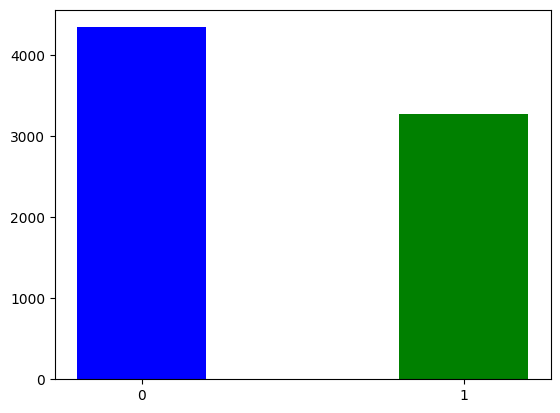

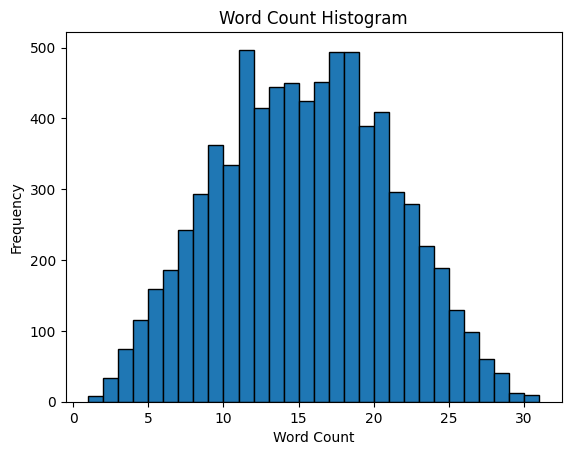

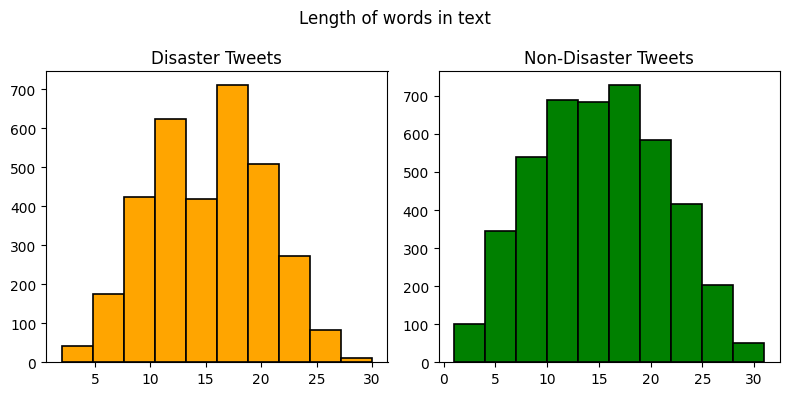

<ipython-input-28-75f68adfe0c2>:98: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(char_len_dis.map(lambda x: np.mean(x)),ax=ax1,color='pink')
<ipython-input-28-75f68adfe0c2>:102: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(char_len_ndis.map(lambda x: np.mean(x)),ax=ax2,color='yellow')


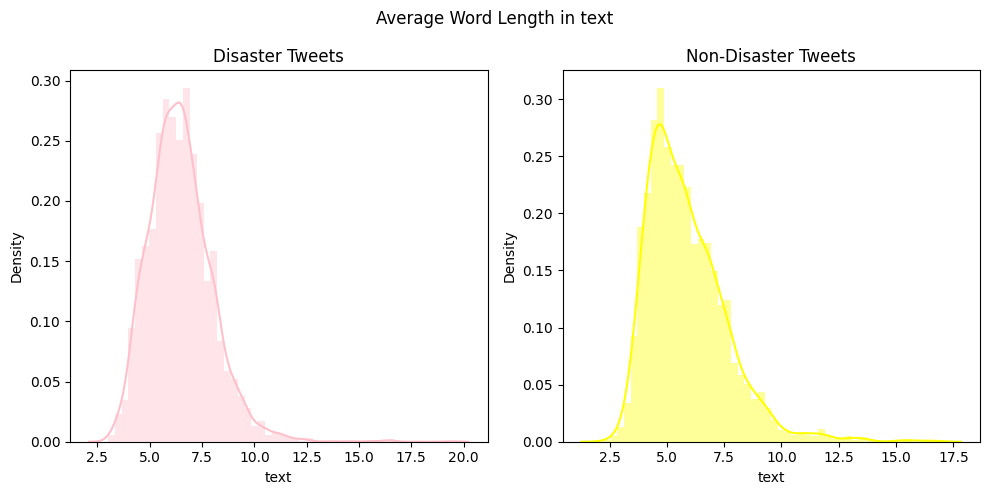

,id,keyword,location,text,target,length,word_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,69,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,133,22
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,65,8
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,88,16
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1,110,18
6,10,NaN,NaN,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1,95,14
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in the woods...,1,59,15
8,14,NaN,NaN,There's an emergency evacuation happening now in the building across the street,1,79,12
9,15,NaN,NaN,I'm afraid that the tornado is coming to our area...,1,52,10


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
!pip install pandas tensorflow keras keras-nlp scikit-learn
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_columns = 10
pd.options.display.max_rows = 20
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_colwidth = 200

print("\nTensorFlow version:", tf.__version__)
print("\nKerasNLP version:", keras_nlp.__version__)


df_train = pd.read_csv('/kaggle/input/disaster-tweets/train.csv')
df_test = pd.read_csv('/kaggle/input/disaster-tweets/test.csv')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print('\nTraining Set Shape = {}'.format(df_train.shape))
print('\nTraining Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('\nTest Set Shape = {}'.format(df_test.shape))
print('\nTest Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

print('\nInfo about the training set:\n', df_train.info())
print('\nInfo about the test set:\n', df_test.info())


# There are missing values in location and keyboard

per_keyword = df_train['keyword'].isna().sum() / df_train['keyword'].count() * 100
print(f"\nThe percentage of NaN values in 'keyword' column in the training set is: {per_keyword:.2f}%")

per_loc = df_train['location'].isna().sum() / df_train['location'].count() * 100
print(f"\nThe percentage of NaN values in 'location' column in the training set is: {per_loc:.2f}%")

per_keyword_test = df_test['keyword'].isna().sum() / df_test['keyword'].count() * 100
print(f"\nThe percentage of NaN values in 'keyword' column in the test set is: {per_keyword_test:.2f}%")

per_loc_test = df_test['location'].isna().sum() / df_test['location'].count() * 100
print(f"\nThe percentage of NaN values in 'location' column in the test set is: {per_loc_test:.2f}%")


# The amount of missing values are the more or less the same in both the train and the test dataset

df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("\nTrain Length Stat\n", df_train["length"].describe())

print("\nTest Length Stat\n", df_test["length"].describe())


# Overview of the target feature

df_count_target = df_train['target'].value_counts()
plt.bar(df_count_target.index, df_count_target, width=0.4, color=['blue', 'green'])
plt.xticks([0, 1])
plt.show()


# Word count

df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))

plt.hist(df_train['word_count'], bins=30, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Histogram')
plt.show()


fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,4))
char_len_dis = df_train[df_train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(char_len_dis,color='orange',edgecolor='black', linewidth=1.2)
ax1.set_title('Disaster Tweets')

char_len_ndis = df_train[df_train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(char_len_ndis,color='green',edgecolor='black', linewidth=1.2)
ax2.set_title('Non-Disaster Tweets')

plt.suptitle("Length of words in text")
plt.tight_layout()
plt.show()


# Character count

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

char_len_dis = df_train[df_train['target']==1]['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(char_len_dis.map(lambda x: np.mean(x)),ax=ax1,color='pink')
ax1.set_title('Disaster Tweets')

char_len_ndis = df_train[df_train['target']==0]['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(char_len_ndis.map(lambda x: np.mean(x)),ax=ax2,color='yellow')
ax2.set_title('Non-Disaster Tweets')

plt.suptitle("Average Word Length in text")
plt.tight_layout()
plt.show()

df_train.head(20)


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import re

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')


def clean_text(each_text):

    each_text_no_url = re.sub(r"http\S+", "", each_text)

    text_no_num = re.sub(r'\d+', '', each_text_no_url)

    word_tokens = word_tokenize(text_no_num)

    clean_tokens = [word.lower() for word in word_tokens if word.isalnum()]

    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in clean_tokens if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    return " ".join(" ".join(lemmatized_tokens).split())


df_train['clean_text'] = df_train['text'].apply(lambda x: clean_text(x) )
df_train['keyword'] = df_train['keyword'].fillna("none")
df_train['clean_keyword'] = df_train['keyword'].apply(lambda x: clean_text(x) )

df_test['clean_text'] = df_test['text'].apply(lambda x: clean_text(x) )
df_test['keyword'] = df_test['keyword'].fillna("none")
df_test['clean_keyword'] = df_test['keyword'].apply(lambda x: clean_text(x) )

np.random.seed(23)
df_train.sample(10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,id,keyword,location,text,target,length,word_count,clean_text,clean_keyword
1461,2109,catastrophe,NaN,.@robdelaney Catastrophe is anything but! I literally have been unable to stop ejaculating.,1,92,13,robdelaney catastrophe anything literally unable stop ejaculating,catastrophe
1837,2642,crashed,too far,He was only .4 of a second faster than me and I overtook him twice (then crashed) tru luv &lt;3 &lt;3,0,101,21,second faster overtook twice crashed tru luv lt lt,crashed
6144,8763,siren,NaN,Internet firms to be subject to new cybersecurity rules in EU... http://t.co/lafTJ2GyLY,0,87,12,internet firm subject new cybersecurity rule eu,siren
2354,3389,demolition,"ÌÏT: 36.142163,-95.979189",@samajp32 really needs to tone it down some in the weight room. RT @SoonerSportsTV: Demolition (cont) http://t.co/2o7Eva1cOe,0,124,17,samajp really need tone weight room rt soonersportstv demolition cont,demolition
4765,6781,lightning,Elchilicitanierraversal,#NowPlaying 'The Lightning Strike' de Snow Patrol de A Hundred Million Suns ? http://t.co/GrzcHkDF37,0,100,14,nowplaying lightning strike de snow patrol de hundred million sun,lightning
6882,9866,traumatised,cork,@AnnmarieRonan @niamhosullivanx I can't watch tat show its like a horror movie to me I get flashbacks an everything #traumatised,0,128,20,annmarieronan niamhosullivanx ca watch tat show like horror movie get flashback everything traumatised,traumatised
3566,5097,famine,NaN,when things become terrible more than the great Ethiopian famine...,0,67,10,thing become terrible great ethiopian famine,famine
1847,2657,crush,NaN,'@jorrynja: 6. @ your bf/gf/crush ??' @Ter_ell ??,1,49,8,jorrynja,crush
4961,7071,meltdown,"Colorado, USA",@nprfreshair I really can't believe he is skipping out before the Republican meltdown...I mean 'debate'.,0,104,15,nprfreshair really ca believe skipping republican meltdown mean,meltdown
7021,10064,typhoon,"Ibadan,Oyo state",Obama Declares Disaster for Typhoon-Devastated Saipan: Obama signs disaster declaration for Northern Marians a... http://t.co/UsVyHdG9OG,1,136,15,obama declares disaster saipan obama sign disaster declaration northern marians,typhoon


In [ ]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from nltk import text
from keras.preprocessing import text
from keras.preprocessing import sequence

xtrain, xtest, ytrain, ytest = train_test_split(df_train['clean_text'].values, df_train['target'].values, shuffle=True, test_size=0.2)

max_words = 20000
tokenizer = Tokenizer(num_words=max_words)

tokenizer.fit_on_texts(xtrain)

xtrain_seq = tokenizer.texts_to_sequences(xtrain)
xtest_seq = tokenizer.texts_to_sequences(xtest)


# https://sandipanweb.wordpress.com/2023/03/31/nlp-disaster-tweets-kaggle-mini-project/


# pad the sequences

max_len = max(df_train['text'].apply(lambda x: len(x.split())).values)

xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_len)
word_index = tokenizer.word_index

xtrain_pad

print('text example:', xtrain[0])
print('sequence of indices(before padding):', xtrain_seq[0])
print('sequence of indices(after padding):', xtrain_pad[0])


text example: flood ukfloods british trekker rescued amid flash flood himalaya group british tr flooding
sequence of indices(before padding): [43, 4878, 930, 4879, 286, 571, 638, 43, 2550, 270, 930, 3279, 152]
sequence of indices(after padding): [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0   43 4878  930 4879  286  571  638   43 2550  270
  930 3279  152]


In [ ]:
#https://nlp.stanford.edu/projects/glove/
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip g*zip

embedding_vectors = {}
with open('glove.6B.300d.txt','r',encoding='utf-8') as file: #glove.42B.300d.txt
    for row in file:
        values = row.split(' ')
        word = values[0]
        weights = np.asarray([float(val) for val in values[1:]])
        embedding_vectors[word] = weights
print(f"Size of vocabulary in GloVe: {len(embedding_vectors)}")



--2024-02-06 14:19:27--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-02-06 14:19:27--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove.6B.zip.1      100%[===================>] 822.24M  5.00MB/s    in 2m 39s  

2024-02-06 14:22:06 (5.18 MB/s) - ‘glove.6B.zip.1’ saved [862182613/862182613]

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: Size of vocabulary

In [ ]:
from keras.layers import Dropout, Embedding, GRU, Dropout, Dense, LSTM
from keras.models import Sequential


model_lstm = Sequential(name='model_lstm')
model_lstm.add(Embedding(vocab_len, emb_dim, trainable = False, weights=[embedding_matrix]))

#model_lstm.add(Embedding(vocab_len, emb_dim, trainable = True))
model_lstm.add(LSTM(64, activation='tanh', return_sequences=False))
model_lstm.add(Dense(128, activation='relu'))

#model_lstm.add(tf.keras.layers.BatchNormalization())
model_lstm.add(Dropout(0.2)) # Adding Dropout layer with rate of 0.2
model_lstm.add(Dense(256, activation='relu'))
model_lstm.add(Dense(128, activation='relu'))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
model_lstm.summary()


Model: "model_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         6000000   
                                                                 
 lstm_1 (LSTM)               (None, 64)                93440     
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 64)                8

In [ ]:
from keras.layers import GRU

emb_dim = embedding_matrix.shape[1]
model_gru = Sequential(name='model_gru')

model_gru.add(Embedding(vocab_len, emb_dim, trainable = False, weights=[embedding_matrix]))
model_gru.add(GRU(128, return_sequences=False))
model_gru.add(Dropout(0.5))
model_gru.add(Dense(1, activation = 'sigmoid'))
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_gru.summary()

Model: "model_gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 300)         6000000   
                                                                 
 gru (GRU)                   (None, 128)               165120    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 6165249 (23.52 MB)
Trainable params: 165249 (645.50 KB)
Non-trainable params: 6000000 (22.89 MB)
_________________________________________________________________


In [ ]:
from tensorflow.keras.layers import TextVectorization, Bidirectional
from tensorflow.keras.metrics import Recall

max_features = 20000 #  20000 most frequent words in the input text data.

vectorizer = TextVectorization(max_tokens=max_features, output_sequence_length=200, output_mode='int')
vectorizer.adapt(np.hstack((xtrain, xtest)))
vectorizerd_text = vectorizer(xtrain)

dataset = tf.data.Dataset.from_tensor_slices((vectorizerd_text, ytrain))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(32)
dataset = dataset.prefetch(8)
batch_X, batch_y = dataset.as_numpy_iterator().next()

train = dataset.take(int(len(dataset)*.8))
val = dataset.skip(int(len(dataset)*.8)).take(int(len(dataset)*.2))

model_bilstm = Sequential(name='model_bilstm')
model_bilstm.add(Embedding(max_features + 1, 64))
model_bilstm.add(Bidirectional(LSTM(64, activation='tanh')))
model_bilstm.add(Dense(128, activation='relu'))
model_bilstm.add(Dropout(0.2)) # Adding Dropout layer with dropout rate of 0.2
model_bilstm.add(Dense(256, activation='relu'))
model_bilstm.add(Dense(128, activation='relu'))
model_bilstm.add(Dense(64, activation='relu'))
model_bilstm.add(Dense(1, activation='sigmoid'))
model_bilstm.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics=[Recall()])
model_bilstm.summary()

Model: "model_bilstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 64)          1280064   
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                                 
 dense_12 (Dense)            (None, 128)               16512     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 256)               33024     
                                                                 
 dense_14 (Dense)            (None, 128)               32896     
                                                      

In [ ]:
import tensorflow_hub as hub

def get_BERT_model():
    # Preprocessing
    tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
    # Bert encoder
    tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2'
    bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
    bert_model = hub.KerasLayer(tfhub_handle_encoder)
    input_layer = tf.keras.layers.Input(shape=(), dtype=tf.string, name='tweets')
    x = bert_preprocess_model(input_layer)
    x = bert_model(x)['pooled_output']
    x = tf.keras.layers.Dropout(0.5)(x) #Optional, to eliminate overfitting
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    classification_out = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(x)
    bert_preprocess_model._name = "preprocess"
    bert_model._name = "bert_encoder"
    model_bert = tf.keras.Model(input_layer, classification_out)
    model_bert._name = "model_bert"
    return model_bert

model_bert = get_BERT_model()
model_bert.summary()

Model: "model_bert"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 tweets (InputLayer)         [(None,)]                    0         []                            
                                                                                                  
 preprocess (KerasLayer)     {'input_type_ids': (None,    0         ['tweets[0][0]']              
                             128),                                                                
                              'input_word_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                           

In [ ]:
transfer_model_url = 'https://tfhub.dev/google/universal-sentence-encoder-cmlm/en-base/1'
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],  # shape of inputs coming to our model
                                        dtype=tf.string,  # data type of inputs coming to the USE layer
                                        trainable=False,
                                        # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

model_use = tf.keras.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
], name = 'transfer_mode')
model_use.summary()

Model: "transfer_mode"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 16)                8208      
                                                                 
 dense_19 (Dense)            (None, 16)                272       
                                                                 
 dense_20 (Dense)            (None, 1)                 17        
                                                                 
Total params: 256806321 (979.64 MB)
Trainable params: 8497 (33.19 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
#initialize the embedding_matrix with zeros
emb_dim = 300
vocab_len = max_words if max_words is not None else len(word_index)+1
embedding_matrix = np.zeros((vocab_len, emb_dim))
oov_count = 0
oov_words = []

for word, idx in word_index.items():
    if idx < vocab_len:
        embedding_vector = embedding_vectors.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
        else:
            oov_count += 1
            oov_words.append(word)

#print some of the out of vocabulary words
print(f'Some out of valubulary words: {oov_words[0:5]}')
print(f'{oov_count} out of {vocab_len} words were OOV.')


NameError: name 'embedding_vectors' is not defined

## **Text Processing**

In [ ]:
import re, string

!pip install symspellpy
from symspellpy import SymSpell, Verbosity

import spacy
import os

!pip install sentence_transformers
from sentence_transformers import SentenceTransformer

from sklearn.metrics.pairwise import cosine_similarity


# Lowercasing

df_train['keyword'] = df_train['keyword'].apply(lambda x: str.lower(x) if pd.isna(x) != True else x)
df_train['location'] = df_train['location'].apply(lambda x: str.lower(x) if pd.isna(x) != True else x)
df_train['text'] = df_train['text'].apply(lambda x: str.lower(x))

df_test['keyword'] = df_test['keyword'].apply(lambda x: str.lower(x) if pd.isna(x) != True else x)
df_test['location'] = df_test['location'].apply(lambda x: str.lower(x) if pd.isna(x) != True else x)
df_test['text'] = df_test['text'].apply(lambda x: str.lower(x))


# Punctuation removal

def remove_ent(text):
    ent_prefixes = ['@', '#']
    for separator in string.punctuation:
        if separator not in ent_prefixes:
            text = text.replace(separator, ' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in ent_prefixes:
                words.append(word)
    return ' '.join(words)

df_train['keyword'] = df_train['keyword'].apply(lambda x: remove_ent(x) if pd.isna(x) != True else x)
df_train['location'] = df_train['location'].apply(lambda x: remove_ent(x) if pd.isna(x) != True else x)
df_train['text'] = df_train['text'].apply(lambda x: remove_ent(x))

df_test['keyword'] = df_test['keyword'].apply(lambda x: remove_ent(x) if pd.isna(x) != True else x)
df_test['location'] = df_test['location'].apply(lambda x: remove_ent(x) if pd.isna(x) != True else x)
df_test['text'] = df_test['text'].apply(lambda x: remove_ent(x))


# Spelling Correction

sym_spell = SymSpell()

dictionary_path = '/kaggle/input/frequency-dictionary/frequency_dictionary_en_82_765.txt'

sym_spell.load_dictionary(dictionary_path, 0, 1)

def spelling_correction(sent):
    doc_w_cor_spelling = []
    for tok in sent.split(' '):

        x = sym_spell.lookup(tok, Verbosity.CLOSEST, max_edit_distance = 2, include_unknown=True)[0].__str__()
        y = x.split(',')[0]
        doc_w_cor_spelling.append(y)

    return " ".join(doc_w_cor_spelling)

df_train['keyword'] = df_train['keyword'].apply(lambda x: spelling_correction(x) if pd.isna(x) != True else x)
df_train['location'] = df_train['location'].apply(lambda x: spelling_correction(x) if pd.isna(x) != True else x)
df_train['text'] = df_train['text'].apply(lambda x: spelling_correction(x))

df_test['keyword'] = df_test['keyword'].apply(lambda x: spelling_correction(x) if pd.isna(x) != True else x)
df_test['location'] = df_test['location'].apply(lambda x: spelling_correction(x) if pd.isna(x) != True else x)
df_test['text'] = df_test['text'].apply(lambda x: spelling_correction(x))

df_train.head(40)


# Keyword extraction

os.system('python -m spacy download en')
nlp = spacy.load('en_core_web_sm')

def extract_keywords(nlp=nlp, doc="", no_of_keywords=5, model=model):

    doc = doc.lower()
    doc = re.sub(r'?:\@|http?\://|https?\://|www\S+', ' ', doc)
    doc = re.sub(r'[^\w\s]', ' ', doc)
    doc = re.sub(' \d+', ' ', doc)

    doc_ = nlp(doc)


    pos_tag = ['VERB', 'NOUN', 'AJD', 'PROPN']
    result = []

    for token in doc_:
        if (token.pos_ in pos_tag):
            result.append(token.text)

doc_embedding = model.encode([doc])
results_embeddings = model.encode(result)


distances = cosine_similarity(doc_embedding, results_embeddings)


keywords = [result[index] for index in distances.argsort()[0][-no_of_keywords:]]

return keywords

# https://medium.com/analytics-vidhya/introduction-to-nlp-with-disaster-tweets-3b672a75748c

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 5.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for editdistpy: filename=editdistpy-0.1.3-cp310-cp310-linux_x86_64.whl size=187471 sha256=7286b79adb0156d255e39b00ee3aeadf7b1f5c40f6f42b0cbe569a06d844893c
  Stored in directory: /root/.cache/pip/wheels/88/6a/a6/a1283cc145323a1fb3d475bd158ee60b248ab1985230d266fc
Successfully built editdistpy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 2.0 MB/s eta 0:00:00


NameError: name 'model' is not defined

In [ ]:
# Vectorize text
vectorizer = CountVectorizer()
X_train_GBC = vectorizer.fit_transform(X_train_GBC)
x_test_GBC = vectorizer.transform(x_test_GBC


model = ensemble.GradientBoostingClassifier(learning_rate=0.1,
                                            n_estimators=2000,
                                            max_depth=9,
                                            min_samples_split=6,
                                            min_samples_leaf=2,
                                            max_features=8,
                                            subsample=0.9)
model.fit(X_train_GBC, y_train)

In [ ]:
# Evaluate the model
predicted_prob = model.predict_proba(x_test_GBC)[:,1]
predicted = model.predict(x_test_GBC)

accuracy = metrics.accuracy_score(predicted, y_test)
print("Test accuracy: ", accuracy)
print(metrics.classification_report(y_test, predicted, target_names=["0", "1"]))
print("Test F-scoare: ", metrics.f1_score(y_test, predicted))


# Read word embeddings
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))
# Define embedding layer in Keras
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = tf.keras.layers.Embedding(vocab_size,embedding_dim,weights[embedding_matrix],input_length=sequence_len,trainable=False)

# For the LSTM model, I have started with an embedding layer to generate an embedding vector for each input sequence. Then I used a convolution model to lower
# the number of features followed by a bidirectional LSTM layer. The last layer is a dense layer. Because it is a binary classification we use sigmoid as an activation function.


# Define model architecture
sequence_input = Input(shape=(sequence_len, ), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)

x = Conv1D(128, 5, activation='relu')(embedding_sequences)
x = Bidirectional(LSTM(128, dropout=0.5, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(sequence_input, outputs)
model.summary()

# Optimize the model
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])



In [ ]:
sample = pd.read_csv('/kaggle/input/disaster-tweets/sample_submission.csv')


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

test.info()